In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Cargar los datos en un DataFrame ---
from io import StringIO



df = pd.read_csv("datos_consumo.csv")

# --- Visualizar los datos ---
plt.figure(figsize=(10, 4))
plt.plot(df["Timestamp"], df["energy"], marker='o')
plt.title("Consumo de energía")
plt.xlabel("Timestamp")
plt.ylabel("Energía")
plt.grid(True)
plt.show()

# --- Detectar cambios bruscos ---
df["delta"] = df["energy"].diff().abs()
umbral = 15000  # cambio significativo de energía
cambios = df[df["delta"] > umbral]

print("Cambios detectados:")
print(cambios[["timestamp", "energy", "delta"]])

# --- Comparar ventanas antes y después del primer cambio ---
if not cambios.empty:
    idx = cambios.index[0]
    ventana = 3  # muestras antes y después

    antes = df.iloc[idx - ventana:idx]["energy"]
    despues = df.iloc[idx + 1:idx + 1 + ventana]["energy"]

    promedio_antes = antes.mean()
    promedio_despues = despues.mean()

    print(f"\nPromedio antes del cambio: {promedio_antes:.2f}")
    print(f"Promedio después del cambio: {promedio_despues:.2f}")
    print(f"Diferencia: {promedio_antes - promedio_despues:.2f}")
else:
    print("No se detectaron cambios grandes en el consumo.")


KeyError: 'energy'

<Figure size 1000x400 with 0 Axes>

Se detectaron 7 eventos de encendido del LED.
Energía entre encendido 0 y 1: 11.691792363 J
Energía entre encendido 1 y 2: 17.578369134 J
Energía entre encendido 2 y 3: 3.620897095 J
Energía entre encendido 3 y 4: 19.909826002 J
Energía entre encendido 4 y 5: 16.052123180 J
Energía entre encendido 5 y 6: 12.982198436 J


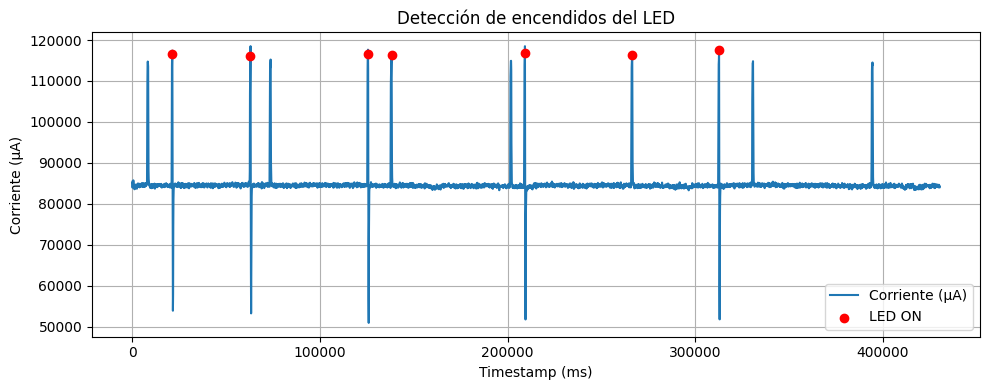

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Parámetros del sistema
VOLTAGE_V = 3.3  # Voltaje de operación en voltios
CURRENT_THRESHOLD_UA = 60000  # Umbral para considerar "LED encendido" (ajusta según tu sistema)

# Leer archivo CSV
data = pd.read_csv("datos_consumo.csv", header=None, names=["timestamp", "current_uA", "flags"])

# Calcular delta de tiempo (en segundos)
data["delta_t_s"] = data["timestamp"].diff() / 1000.0

# Convertir corriente a amperios
data["current_A"] = data["current_uA"] / 1_000_000.0

# Calcular energía por intervalo: E = I * V * dt
data["energy_J"] = data["current_A"] * VOLTAGE_V * data["delta_t_s"]

# Identificar los momentos de encendido del LED
data["led_on"] = data["current_uA"] < CURRENT_THRESHOLD_UA

# Detectar flancos ascendentes: cuando el LED pasa de apagado a encendido
data["led_on_shifted"] = data["led_on"].shift(fill_value=False)
data["rising_edge"] = (data["led_on"] & ~data["led_on_shifted"])

# Obtener índices de subida de corriente (LED encendido)
rising_edges = data.index[data["rising_edge"]].tolist()

# Mostrar resultados
print(f"Se detectaron {len(rising_edges)} eventos de encendido del LED.")

# Calcular energía entre pares de eventos (de un encendido al siguiente)
for i in range(len(rising_edges) - 1):
    start = rising_edges[i]
    end = rising_edges[i + 1]
    energy = data.loc[start:end, "energy_J"].sum()
    print(f"Energía entre encendido {i} y {i+1}: {energy:.9f} J")

# (Opcional) Graficar corriente
plt.figure(figsize=(10, 4))
plt.plot(data["timestamp"], data["current_uA"], label="Corriente (µA)")
plt.scatter(data.loc[rising_edges, "timestamp"], data.loc[rising_edges, "current_uA"], color='red', label="LED ON", zorder=5)
plt.xlabel("Timestamp (ms)")
plt.ylabel("Corriente (µA)")
plt.title("Detección de encendidos del LED")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
